# MDP - Résolution par programmation dynamique (Value Iteration & Policy Iteration)

*Version 1 - Elise Chin, December 2021*

1. [Value Iteration](#sec1)
2. [Policy Iteration](#sec2)

Supposons que le modèle de transition soit connu. On souhaite trouver une politique optimale pour un problème donné formulé comme un processus décisionnel de Markov (MDP). L'idée est d'utiliser l'expression de droite des équations de Bellman pour converger vers la fonction de valeur optimale pour les états $v_*$ ou la fonction de valeurs optimale pour les paires état-actions $q_*$ grâce à des algorithmes itératifs. On en déduit ensuite la politique optimale :

$$
\pi_*(s) = \underset{a}{\operatorname{argmax}} q_*(s,a).
$$


On va utiliser l'exemple du monde grille simple. 

![Grid World](https://www.lamsade.dauphine.fr/~airiau/Teaching/M2-IASDapp-RL/gridworld.png)



On va numéroter les états comme suit :

| 7 | 8 | 9 | 10 |
|---|---|----|---|
| **4** |  - | **5** | **6**  |
| **0** | **1** | **2** | **3**  |

Les états finaux sont donc les états 6 et 10.

On a 4 actions disponibles, on les encode de la façon suivante :
* $\uparrow$: 0 
* $\leftarrow$ : 1
* $\downarrow$: 2
* $\rightarrow$ : 3

Ci-dessous, on a entré la matrice de transition $T$ et la matrice de récompense $R$. Ainsi $T[s_1,a,s_2]$ donne la probabilité d'atteindre l'état $s_2$ en ayant pris l'action $a$ dans l'état $s_1$ et $R[s,a]$ donne la récompense immédiate reçue après avoir pris l'action $a$ dans l'état $s$.

Vous pouvez facilement changer la pénalité pour avancer d'une case en changeant la valeur de la variable `penalty` ci-dessous.

Ce n'est peut-être pas la manière la plus élégante, mais cela suffira pour l'exercice !

On connaît le modèle de transition 

$$
p(s' | s,a) = \mathbb{P}[S_{t+1} = s' | S_t = s, A_t = a]
$$

défini par la matrice $T$ et le modèle de récompense 

$$
r(s,a) = \mathbb{E}[R_{t+1} | S_t = s, A_t = a]
$$

défini par la matrice $R$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
l = 0.8
s = 0.1
v_win = 1
v_lose = -1

# Transition Matrix
T = np.zeros((11, 4, 11))

# UP
T[0,0,:]=[s, s, 0, 0, l, 0, 0, 0, 0, 0, 0 ] 
T[1,0,:]=[s, l, s, 0, 0, 0, 0, 0, 0, 0, 0 ]
T[2,0,:]=[0, s, 0, s, 0, l, 0, 0, 0, 0, 0 ]
T[3,0,:]=[0, 0, s, s, 0, 0, l, 0, 0, 0, 0 ]
T[4,0,:]=[0, 0, 0, 0, 2*s, 0, 0, l, 0, 0, 0 ]
T[5,0,:]=[0, 0, 0, 0, 0, s, s, 0, 0, l, 0 ]
T[6,0,:]=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ]
T[7,0,:]=[0, 0, 0, 0, 0, 0, 0, s+l, s, 0, 0 ]
T[8,0,:]=[0, 0, 0, 0, 0, 0, 0, s, l, s, 0 ]
T[9,0,:]=[0, 0, 0, 0, 0, 0, 0, 0, s, l, s ]
T[10,0,:]=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0 ]

# LEFT
T[0,1,:]=[s+l, 0, 0, 0, s, 0, 0, 0, 0, 0, 0 ] 
T[1,1,:]=[l, 2*s, 0, 0, 0, 0, 0, 0, 0, 0, 0 ]
T[2,1,:]=[0, l, s, 0, 0, s, 0, 0, 0, 0, 0 ]
T[3,1,:]=[0, 0, l, s, 0, 0, s, 0, 0, 0, 0 ]
T[4,1,:]=[s, 0, 0, 0, l, 0, 0, s, 0, 0, 0 ]
T[5,1,:]=[0, 0, s, 0, 0, l, 0, 0, 0, s, 0 ]
T[6,1,:]=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ]
T[7,1,:]=[0, 0, 0, 0, s, 0, 0, s+l, 0, 0, 0 ]
T[8,1,:]=[0, 0, 0, 0, 0, 0, 0, l, 2*s, 0, 0 ]
T[9,1,:]=[0, 0, 0, 0, 0, s, 0, 0, l, s, 0 ]
T[10,1,:]=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0 ]

# DOWN
T[0,2,:]=[s+l, s, 0, 0, 0, 0, 0, 0, 0, 0, 0 ] 
T[1,2,:]=[s, l, s, 0, 0, 0, 0, 0, 0, 0, 0 ]
T[2,2,:]=[0, s, l, s, 0, 0, 0, 0, 0, 0, 0 ]
T[3,2,:]=[0, 0, s, l+s, 0, 0, 0, 0, 0, 0, 0 ]
T[4,2,:]=[l, 0, 0, 0, 2*s, 0, 0, 0, 0, 0, 0 ]
T[5,2,:]=[0, 0, l, 0, 0, s, s, 0, 0, 0, 0 ]
T[6,2,:]=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ]
T[7,2,:]=[0, 0, 0, 0, l, 0, 0, s, s, 0, 0 ]
T[8,2,:]=[0, 0, 0, 0, 0, 0, 0, s, l, s, 0 ]
T[9,2,:]=[0, 0, 0, 0, 0, 0, 0, 0, s, l, s ]
T[10,2,:]=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0 ]

# RIGHT
T[0,3,:]=[s, l, 0, 0, s, 0, 0, 0, 0, 0, 0 ] 
T[1,3,:]=[0, 2*s, l, 0, 0, 0, 0, 0, 0, 0, 0 ]
T[2,3,:]=[0, 0, s, l, 0, s, 0, 0, 0, 0, 0 ]
T[3,3,:]=[0, 0, 0, s+l, 0, 0, s, 0, 0, 0, 0 ]
T[4,3,:]=[s, 0, 0, 0, l, 0, 0, s, 0, 0, 0 ]
T[5,3,:]=[0, 0, s, 0, 0, 0, l, 0, 0, s, 0 ]
T[6,3,:]=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ]
T[7,3,:]=[0, 0, 0, 0, s, 0, 0, s, l, 0, 0 ]
T[8,3,:]=[0, 0, 0, 0, 0, 0, 0, 0, 2*s, l, 0 ]
T[9,3,:]=[0, 0, 0, 0, 0, s, 0, 0, 0, s, l ]
T[10,3,:]=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0 ]


# Reward matrix
penalty = 0.00
R = penalty * np.ones((11,4))
R[10,:] = np.ones(4) * v_win
R[6,:] = np.ones(4) * v_lose

In [3]:
class Environment():
    
    def __init__(self, observation_space, action_space, transition_matrix, reward_matrix):
        self.observation_space = observation_space
        self.action_space = action_space
        self.n_states = len(observation_space) # Number of actions
        self.n_actions = len(action_space) # Number of spaces
        self.T = transition_matrix 
        self.R = reward_matrix

In [4]:
observation_space = list(range(11))
action_space = list(range(4))
env = Environment(observation_space, action_space, T, R)

## <a name="sec1">1. Value Iteration</a>

L'algorithme d'itération sur les valeurs permet de trouver la fonction de valeur optimale $v_*$ par une méthode itérative. Il est basé sur les équations d'optimalité de Bellman.

On sait que 
$$
v_*(s) = \underset{a \in \mathcal{A}}{\operatorname{max}} q_*(s,a) 
$$
et que 
$$
q_*(s,a) = r(s,a) + \gamma \sum_{s' \in \mathcal{S}} p(s'|s,a) v_*(s')
$$

Donc 
$$
v_*(s) = \underset{a \in \mathcal{A}}{\operatorname{max}} r(s,a) + \gamma \sum_{s' \in \mathcal{S}} p(s'|s,a) v_*(s')
$$

La solution de l'équation de Bellman optimale est l'unique point fixe de l'opérateur de Bellman $\tau$, i.e. la suite $v_{k+1} = \tau v_k$ converge vers $v_*$. Pour trouver la solution, on peut donc appliquer itérativement l'opérateur pour converger vers l'optimal : 

$$
v_{k+1}(s) = \underset{a \in \mathcal{A}}{\operatorname{max}} r(s,a) + \gamma \sum_{s' \in \mathcal{S}} p(s'|s,a) v_k(s')
$$

La fonction `value_iteration()` prend en paramètres :
- `env` l'environnement décrit par la matrice de transition $T$ et la matrice de récompense $R$
- `gamma` le taux d'escompte (i.e. la valeur à l'instant $t$ d'obtenir une unité de récompense à l'instant $t+1$)
- `max_iter` le nombre d'itérations maximal
- `epsilon` le paramètre pour le test d'arrêt

La méthode retourne le vecteur $v: S \rightarrow {\mathbb R}$ qui associe à chaque état la valeur optimale de cet état.

Pour la mise à jour des valeurs de $v$, on utilisera une fonction intermédiaire `compute_action_value()` qui permet de calculer $q(s,a)$ étant donné un état $s$, une action $a$ et l'estimation courante de $v$.

In [5]:
def compute_action_value(env, gamma, s, a, v):
    '''Compute q_pi(s,a) given v_pi(s)'''

    action_value = env.R[s,a] + gamma * sum([env.T[s,a,next_s]*v[next_s] for next_s in range(env.n_states)])
    return action_value

In [9]:
def value_iteration(env, gamma, max_iter=100, epsilon=1e-2):
    
    v = np.zeros(env.n_states)
    
    for i in range(max_iter):
        delta = 0

        # For each state...
        for s in range(env.n_states):

            # Get the current estimation for state s, to compute delta
            vs = v[s]
            
            # Compute action value function with current estimate of v
            action_values = np.array([compute_action_value(env, gamma, s, a, v) for a in range(env.n_actions)])
            
            # Update v for state s
            v[s] = np.max(action_values)
            
            # Update the biggest difference
            delta = np.max([delta, np.abs(vs-v[s])])

        # Convergence test, until delta < epsilon
        if (delta < epsilon):
            print(f'Break after {i} iterations.')
            break
            
    return v    

La fonction $printV$ ci-dessous affichera les valeurs de $v$ pour le problème du gridworld.

In [10]:
def printV(v):
    print('| {:03.2f} | {:03.2f} | {:03.2f} | {:03.2f} |'.format(v[7], v[8], v[9], v[10]))
    print('| {:03.2f} | ---- | {:03.2f} | {:03.1f} |'.format(v[4], v[5], v[6]))
    print('| {:03.2f} | {:03.2f} | {:03.2f} | {:03.2f} |'.format(v[0], v[1], v[2], v[3]))

In [11]:
v = value_iteration(env, gamma=0.9, max_iter=100, epsilon=1e-2)
printV(v)

| 0.00 | 0.00 | 0.00 | 1.00 |
| 0.00 | ---- | 0.00 | -1.0 |
| 0.00 | 0.00 | 0.00 | 0.00 |
| 0.00 | 0.00 | 0.72 | 1.00 |
| 0.00 | ---- | 0.00 | -1.0 |
| 0.00 | 0.00 | 0.00 | 0.00 |
| 0.00 | 0.52 | 0.82 | 1.00 |
| 0.00 | ---- | 0.43 | -1.0 |
| 0.00 | 0.00 | 0.00 | 0.00 |
| 0.37 | 0.69 | 0.84 | 1.00 |
| 0.00 | ---- | 0.54 | -1.0 |
| 0.00 | 0.00 | 0.31 | 0.13 |
| 0.55 | 0.73 | 0.85 | 1.00 |
| 0.27 | ---- | 0.57 | -1.0 |
| 0.00 | 0.22 | 0.42 | 0.23 |
| 0.62 | 0.74 | 0.85 | 1.00 |
| 0.45 | ---- | 0.57 | -1.0 |
| 0.21 | 0.34 | 0.46 | 0.26 |
| 0.64 | 0.74 | 0.85 | 1.00 |
| 0.52 | ---- | 0.57 | -1.0 |
| 0.37 | 0.39 | 0.47 | 0.27 |
| 0.64 | 0.74 | 0.85 | 1.00 |
| 0.55 | ---- | 0.57 | -1.0 |
| 0.45 | 0.41 | 0.47 | 0.27 |
| 0.64 | 0.74 | 0.85 | 1.00 |
| 0.56 | ---- | 0.57 | -1.0 |
| 0.47 | 0.42 | 0.47 | 0.28 |
| 0.64 | 0.74 | 0.85 | 1.00 |
| 0.56 | ---- | 0.57 | -1.0 |
| 0.48 | 0.42 | 0.47 | 0.28 |
| 0.64 | 0.74 | 0.85 | 1.00 |
| 0.57 | ---- | 0.57 | -1.0 |
| 0.49 | 0.43 | 0.48 | 0.28 |
Break afte

In [9]:
# Plot the best policy given the value function v:
# i.e. plot the best action for each state given the value function v.

def plotBestPolicy(v, gamma):
    bestV = np.zeros(11)
    bestA = np.zeros(11)
    fig, ax = plt.subplots()
    
    # Policy extraction
    for s1 in range(11):
        val = []
        for a in range(4):
            va = 0
        for s2 in range(11):
            va += T[s1,a,s2] * v[s2]
        val = val + [R[s1,a] + gamma*va]
        bestV[s1] = np.max(val)
        bestA[s1] = np.argmax(val)

        matV= np.array( [[bestV[7], bestV[8], bestV[9], bestV[10]],
                        [bestV[4],   -1 , bestV[5], bestV[6]],
                        [bestV[0], bestV[1], bestV[2], bestV[3]]]
                        )
        matA = np.array([
                        [bestA[7], bestA[8], bestA[9], -1],
                        [bestA[4],   -1 , bestA[5], -1],
                        [bestA[0], bestA[1], bestA[2], bestA[3]]])

        im = ax.imshow(matV)

    for i in range(matV.shape[0]):
        for j in range(matV.shape[1]):
            if matA[i][j]==-1:
                arrow = ''
            elif matA[i, j] == 0:
                arrow = '^'
            elif matA[i, j] == 1:
                arrow = '<'
            elif matA[i, j] == 2:
                arrow = 'v'
            elif matA[i, j] == 3:
                arrow = '>'
            text = ax.text(j, i, arrow, ha = "center", va = "center",
                            color = "black")
                
    cbar = ax.figure.colorbar(im, ax = ax)
        
    fig.tight_layout()
    plt.show() 

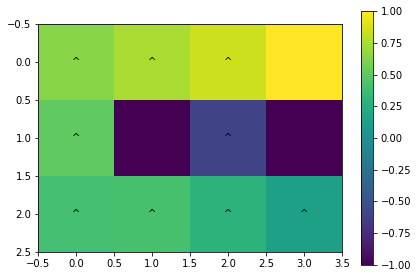

In [10]:
plotBestPolicy(v, 0.9)

## <a name="sec2">2. Policy Iteration</a>

Une autre stratégie pour calculer $v_*$ et $q_*$ est de partir d'une politique arbitraire $\pi$ et de l'améliorer : c'est l'algorithme d'itération sur les politiques. Il se décompose en deux phases qu'on alterne jusqu'à ce qu'on converge vers une politique qui sera la politique optimale :
1. Evaluation de la politique
2. Amélioration de la politique


__Evaluation de la politique__

Etant donné $\pi$, on cherche à calculer $v_{\pi}(s)$ pour tout $s \in \mathcal{S}$. L'idée est de partir d'une estimation initiale $v_0$ (e.g. $v_0(s) = 0 \space \forall s$) puis de calculer de nouvelles estimations en utilisant l'expression de droite de l'équation de Bellman pour les valeurs d'états.
Le pseudo-code est le suivant :

1. Initialize $v_{old}$ (e.g. $v_{old}(s) = 0 \space \forall s$)
2. $\forall s \in \mathcal{S}$
$$
v_{new}(s) = \sum_{a \in \mathcal{A}} \pi(a|s) \left(r(s,a) + \gamma \sum_{s' \in \mathcal{S}} p(s'|s,a)v_{\pi}(s') \right)
$$
3. If |$v_{old}(s) - v_{new}(s)$| < tol $\forall s$, output $v_{new}$ and stop
4. Otherwise, let $v_{old} ← v_{new}$ and step 2

__Amélioration de la politique__

Une fois $v_{\pi}$ évaluée, on peut calculer $
q_{\pi}(s,a) = r(s,a) + \gamma \sum_{s' \in \mathcal{S}} p(s'|s,a) v_{\pi}(s')$. Puis à partir de $q_{\pi}$, améliorer la politique en se comportant de manière "gloutonne", c'est-à-dire :
$$
\pi'(s) = \underset{a}{\operatorname{argmax}} q_{\pi}(s,a).
$$

L'algorithme d'itération sur les politiques alterne entre ces deux étapes jusqu'à ce qu'aucune amélioration n'a été trouvée. La dernière fonction de valeur évaluée est donc $v_*$ et à partir de cette fonction, on peut en déduire $q_*$ puis $\pi_*$. 

### 2.1 Policy evaluation

Implémentons une fonction pour évaluer une politique. 

Pour cela, nous allons tout d'abord créer une fonction `Bellman_RHS_all()` qui calcule l'expression de droite de l'équation de Bellman pour chaque état, en utilisant la fonction intermédiaire `Bellman_RHS()` qui calcule la valeur pour un état donné.

In [11]:
def Bellman_RHS(env, pi, gamma, s, v):
    '''Compute the right-hand side of the Bellman equation'''

    state_value = 0
    for a in range(env.n_actions):
        state_value += pi[s,a] * compute_action_value(env, gamma, s, a, v)
    return state_value

def Bellman_RHS_all(env, pi, gamma, v0):
    '''Given a value function, computes the right-hand side 
    of the Bellman equation for all states'''

    # v0 is the given value function
    # v will be the right-hand side of the Bellman equation
    # If v0 is indeed the value function, then we should get v = v0.
    
    v = np.zeros(env.n_states)
    for s in range(env.n_states):
        v[s] = Bellman_RHS(env, pi, gamma, s, v0)
    return v

La fonction `policy_evaluation()` permet d'évaluer une politique. On implémente le pseudo-code présenté ci-dessus.

In [12]:
def policy_evaluation(env, pi, gamma, v0, max_iter=100, epsilon=1e-2):
    
    # Initial guess
    v_old = v0
    
    for _ in range(max_iter):
        v_new = Bellman_RHS_all(env, pi, gamma, v_old)
        
        if np.max(np.abs(v_new - v_old)) < epsilon:
            break
        
        v_old = v_new
        
    return v_new

### 2.2 Policy improvement

`policy_improvement()` retourne `pi` qui encode une politique gloutonne selon `v` et `q` calculée à partir de `v`. On a `pi[s][a]`  $= \pi(a|s)$.

In [13]:
def policy_improvement(env, gamma, v):
    
    # The new policy will be a_probs
    # We start by setting all probabilities to 0
    # Then when we have found the greedy action in a state, 
    # we change the probability for that action to 1.0.
    
    pi = np.zeros((env.n_states, env.n_actions))
    q = np.zeros((env.n_states, env.n_actions))

    for s in range(env.n_states):

        # Compute action value for all actions
        for a in range(env.n_actions):
            q[s,a] = compute_action_value(env, gamma, s, a, v)
            
        a_max = np.argmax(q[s]) # A greedy action
        pi[s][a_max] = 1.0 # Always choose the greedy action
        
    return pi, q

### 2.3 Policy iteration 

In [14]:
def policy_iteration(env, gamma, max_iter, epsilon=1e-2):
    
    # Initialisation
    v = np.zeros(env.n_states)
    
    for i in range(max_iter):
        v_old = v
        
        # Policy improvement (i.e. act greedy w.r.t v)
        pi, q = policy_improvement(env, gamma, v_old)
        
        # Policy evaluation
        v = policy_evaluation(env, pi, gamma, v_old)
        
        delta = np.max(np.abs(v_old - v))
        if delta < epsilon:
            print(f'Break after {i} iterations.')
            break
    
    return v, q, pi

In [15]:
v_star, q_star, pi_star = policy_iteration(env, gamma=0.9, max_iter=100, epsilon=1e-2)

Break after 2 iterations.


In [16]:
printV(v_star)

| 0.64 | 0.74 | 0.85 | 1.00 |
| 0.57 | ---- | 0.57 | -1.0 |
| 0.49 | 0.42 | 0.47 | 0.28 |


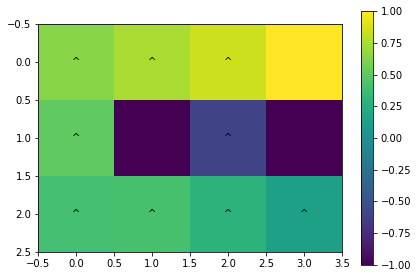

In [17]:
plotBestPolicy(v_star, 0.9)